# Bennets Hipathia Script

## 1. Instalation & Setup

In [31]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

# --- Install BiocManager if missing ---
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

# --- Install or update 'hipathia' from Bioconductor ---
BiocManager::install("hipathia", ask = FALSE, update = TRUE)

# --- Load core libraries ---
library(dplyr)
library(hipathia)
library(data.table)

# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.27), R 4.4.3 (2025-02-28)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'hipathia'”
Old packages: 'Biostrings', 'digest', 'gower', 'IRanges', 'mgcv', 'purrr',
  'rbibutils', 'reshape2', 'RSQLite', 'S7', 'SparseArray', 'xml2'

Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘digest’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘gower’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘IRanges’ h

[1] ‘3.6.0’

[1] ‘1.1.4’

## 2. PARAMETERS

### 2.1 Set Paramter 

In [2]:
# ---- Input files ----
rna_path  <- "rna_data_filtered wtumor.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"
expr_pseudobulk_out  <- "expr_pseudobulk_symbols.csv"
design_out           <- "design.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "Normal"        # name in output (left in Hipathia)
group2_name  <- "Tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p4"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
pseudobulk_method <- "sum"
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways





## PATIENT FILTERING

In [3]:
# Load metadata
meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

# Ensure required columns exist
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Merge pXXXpos / pXXXneg → pXXX (patient-level)
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Filter metadata to keep only the groups defined in the parameter block
meta_filt <- meta[meta[[group_column]] %in% c(group1_types, group2_types), ]

# Count cells per patient × group
cell_counts <- table(meta_filt$patient_id, meta_filt[[group_column]])

# Universal: sum counts for each group1/group2 type (in case multiple celltypes belong to a group)
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Which patients have enough cells from BOTH groups?
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))


# ============================================
# BUILD GROUPED PATIENT × CELLTYPE TABLE
# ============================================

patients <- rownames(cell_counts)

# Reihen in der richtigen Reihenfolge
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

# Matrix erstellen
diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

# Summen für group1
for (p in patients) {
  diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), p] <-
    sum(cell_counts[p, group1_types], na.rm = TRUE)
}

# Summen für group2
for (p in patients) {
  diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), p] <-
    sum(cell_counts[p, group2_types], na.rm = TRUE)
}

# Einzelne Celltypes einfügen
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[, ct])
}

# keep-Zeile
diagnosis_matrix["keep", ] <- ifelse(
  group1_counts >= min_cells & group2_counts >= min_cells,
  "TRUE",
  "FALSE"
)


# In data.frame konvertieren
diagnosis_table <- as.data.frame(diagnosis_matrix)


# Print diagnostic table
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Final metadata restricted to valid patients only
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, ]

# After filtering patients: extract valid cell barcodes
filtered_barcodes <- unique(meta_final$cell_id)

if (length(filtered_barcodes) == 0) {
    stop("Patient filter produced zero remaining cell barcodes.")
}

message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))



                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "Normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "Tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "Normal"     0     0
Mesothelium                0     0
group2_name = "Tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: Normal vs Tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



## 3. RNA Reader & Standardisation

### 3.1 Helper functions

In [32]:

trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]]))
      df[[i]] <- trimws(df[[i]])
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- trimws(as.character(v))
  non_na <- v[!is.na(v)]

  if (length(non_na) == 0) return(FALSE)

  return(
    mean(grepl("[A-Za-z]", non_na)) > 0.5 &&
    mean(nchar(non_na) < 20) > 0.95 &&
    mean(grepl("-", non_na)) < 0.5 &&
    mean(grepl("^\\d+$", non_na)) < 0.1
  )
}

looks_barcode <- function(x) {
  x <- trimws(as.character(x))
  grepl("^[ACGTN]+[-_][0-9]+$", x)
}

# ---- WICHTIG: Die neue fread-basierte read_tab Funktion ----
read_tab <- function(path) {
  fread(path, data.table = FALSE)
}


### 3.2. Read RNA File

In [5]:
rna_raw <- trim_all(rna_raw)

rna_ids <- colnames(rna_raw)
meta_ids <- meta$cell_id

cat("Meta cells:", length(meta_ids), "\n")
cat("RNA cells: ", length(rna_ids), "\n")

cat("Cells in metadata but NOT in RNA:", 
    sum(!(meta_ids %in% rna_ids)), "\n")

# Drop empty columns
empty_cols <- which(sapply(rna_raw, function(x) all(x == "" | is.na(x))))
if (length(empty_cols)) rna_raw <- rna_raw[, -empty_cols, drop = FALSE]

stopifnot(ncol(rna_raw) >= 2)

# Detect gene column (robust)
# 1. Check common gene column names first
gene_name_hits <- which(tolower(colnames(rna_raw)) %in% c("gene", "genes", "symbol", "geneid"))

if (length(gene_name_hits) == 1) {
    gene_col <- gene_name_hits
} else {
    # 2. Fallback: heuristic
    first_col <- rna_raw[[1]]
    if (looks_gene_symbol(head(first_col, 200))) {
        gene_col <- 1
    } else {
        gene_col <- which(sapply(rna_raw, function(col)
            looks_gene_symbol(head(col, 200))))[1]
    }
}

if (is.na(gene_col)) stop("Could not detect gene column.")

colnames(rna_raw)[gene_col] <- "Gene"


Meta cells: 84526 
RNA cells:  1001 
Cells in metadata but NOT in RNA: 83526 


### Check: cells per patient X


In [6]:
# ---- Inspect patient cell composition ----

cat("\n===== Inspecting sample:", inspect_sample, "=====\n")

# Filter for selected patient
meta_inspect <- meta[meta$orig.ident == inspect_sample, ]

if (nrow(meta_inspect) == 0) {
    stop("No cells found for patient: ", inspect_sample)
}

# Unique cell types
unique_celltypes_inspect <- unique(meta_inspect[[group_column]])

cat("\nUnique cell types for patient", inspect_sample, ":\n")
print(unique_celltypes_inspect)

# Count per celltype
table_inspect <- table(meta_inspect[[group_column]])

cat("\nCell counts for patient", inspect_sample, ":\n")
print(table_inspect)

cat("\n===== End inspection for:", inspect_sample, "=====\n\n")



===== Inspecting sample: p4 =====

Unique cell types for patient p4 :
 [1] "TAMs"          "Malignant"     "Mono_CD16"     "CD8"          
 [5] "cDC2"          "KLRC1_NK"      "CD4"           "Mono_CD14"    
 [9] "B_cells"       "Fibroblasts"   "Mesothelium"   "TFH"          
[13] "FGFBP2_NK"     "pDC"           "Tregs"         "Plasma"       
[17] "cDC1"          "SmoothMuscle"  "NKlike_Tcells" "Mast"         
[21] "Vein"          "mregDC"        "PLVAP"        

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
   

### 3.3 Standardization RNA Matrix

In [7]:
rna <- rna_raw

# Gene column
rna$Gene <- as.character(rna$Gene)

# Welche Barcodes dürfen bleiben?
rna_barcodes   <- setdiff(colnames(rna), "Gene")
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

# Relevante Spalten auswählen
rna <- rna[, c("Gene", keep_barcodes), drop = FALSE]

# Bessere Numeric-Erkennung:
# akzeptiert: 1, 1.5, 1e-5, 0E0, NA, "", " "
valid_numeric <- function(x) {
    x <- trimws(x)
    ok <- grepl("^[-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?$", x) | x == "" | is.na(x)
    all(ok)
}

# Konvertiere Barcodes
for (bc in keep_barcodes) {
    if (!valid_numeric(rna[[bc]])) {
        stop("Column ", bc, " contains non-numeric entries. This should not happen in an RNA matrix.")
    }

    rna[[bc]] <- suppressWarnings(as.numeric(trimws(rna[[bc]])))
}

# Drop empty genes
rna$Gene <- trimws(rna$Gene)
rna <- rna[rna$Gene != "", , drop = FALSE]

# Collapse duplicate genes (WICHTIG: keine Sortierung + Barcodes bleiben korrekt)
if (anyDuplicated(rna$Gene)) {
    message("Duplicate genes detected → collapsing by sum.")

    # Aggregiere korrekt und erhalte Barcode-Namen
    rna <- aggregate(
        rna[, keep_barcodes, drop = FALSE],
        by = list(Gene = rna$Gene),
        FUN = sum
    )

    # Stellt sicher, dass Reihenfolge Gene, Barcode1, Barcode2,... bleibt
    rna <- rna[, c("Gene", keep_barcodes), drop = FALSE]
}

# Export
write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 10 barcodes after patient filtering.

Wrote standardized RNA: 10 barcodes kept.



### 3.4. Check: Barcode Overlap AFTER standardization

In [27]:


meta_ids <- meta_final$cell_id             # nur Patienten, die du behalten hast
rna_ids  <- setdiff(colnames(rna), "Gene") # alle Barcodes, die noch in RNA sind

overlap <- intersect(meta_ids, rna_ids)
prop <- length(overlap) / length(rna_ids)

cat("\n===== Barcode Overlap AFTER standardization =====\n")
cat("Remaining RNA barcodes:   ", length(rna_ids), "\n")
cat("Remaining meta barcodes:  ", length(meta_ids), "\n")
cat("Overlap:                  ", length(overlap),
    sprintf(" (%.1f%%)\n", 100 * prop))

if (prop < min_overlap_prop) {
    warning("Barcode overlap after filtering < ",
            100 * min_overlap_prop, "% — check filtering logic.")
}



===== Barcode Overlap AFTER standardization =====
Remaining RNA barcodes:    10 
Remaining meta barcodes:   996 
Overlap:                   10  (100.0%)


### CHECK: Patient filter sanity

In [28]:
# ==============================
# CHECK: Patient filter sanity
# ==============================

message("\n===== PATIENT FILTER CHECK =====")

# 1) Anzahl der Barcodes
message("Barcodes after filtering: ", length(filtered_barcodes))

if (length(filtered_barcodes) == 0) {
    stop("ERROR: No barcodes kept after patient filtering.")
}

# 2) Prüfen ob Barcodes in der RNA-Datei existieren
barcode_cols_in_rna <- setdiff(colnames(rna_raw), "Gene")

missing_in_rna <- setdiff(filtered_barcodes, barcode_cols_in_rna)

if (length(missing_in_rna) > 0) {
    message("WARNING: ", length(missing_in_rna),
            " barcodes are in metadata but missing in the RNA matrix:")
    print(head(missing_in_rna))
} else {
    message("All filtered barcodes exist in the RNA matrix. ✔")
}

# 3) Prüfen ob RNA-Barcodes existieren, die NICHT gefiltert wurden
extra_in_rna <- setdiff(barcode_cols_in_rna, filtered_barcodes)
message("RNA barcodes not part of filtered patients: ", length(extra_in_rna))



===== PATIENT FILTER CHECK =====

Barcodes after filtering: 996




[1] "p786pos_ACTCTCGTCGCTTTAT-1" "p786pos_CTCATGCGTAGAATAC-1"
[3] "p786pos_GATGAGGTCGATTGAC-1" "p786pos_TTCGGTCAGAGTGTTA-1"
[5] "p786neg_AAACCCATCACCGACG-1" "p786neg_AAACGAACAGGTGACA-1"


RNA barcodes not part of filtered patients: 990



In [25]:
# 1. Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# 2. Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes))

# 3. How many barcodes match between RNA and metadata?
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# 4. Which RNA barcodes were NOT kept by the patient filter?
lost <- setdiff(original_rna_barcodes, filtered_barcodes)
message("RNA barcodes discarded by patient filter: ", length(lost))
if (length(lost) > 0) print(head(lost, 20))




Original RNA barcodes: 1000

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 10

RNA barcodes discarded by patient filter: 990



 [1] "p786pos_AAAGGATGTCCCTGAG-1" "p786pos_AAAGGGCCAAGCCCAC-1"
 [3] "p786pos_ACAGAAAGTTCGAACT-1" "p786pos_ACCTACCCACTAACGT-1"
 [5] "p786pos_AGACTCACAATGACCT-1" "p786pos_AGCGTATCAGTTGCGC-1"
 [7] "p786pos_AGCGTATCATCCCACT-1" "p786pos_AGGATCTGTTTACGTG-1"
 [9] "p786pos_AGGGAGTGTTGGGTAG-1" "p786pos_AGGGTTTAGCCTCTTC-1"
[11] "p786pos_AGTGCCGAGTTGGCTT-1" "p786pos_ATCATTCGTCAAAGTA-1"
[13] "p786pos_ATCCACCCAGACGCTC-1" "p786pos_ATGGGAGAGGAGCTGT-1"
[15] "p786pos_ATTCATCAGGTAACTA-1" "p786pos_CCGGTAGTCACCCTGT-1"
[17] "p786pos_CCTCCTCGTTGCATCA-1" "p786pos_CGGAACCTCTACTGAG-1"
[19] "p786pos_CTCAATTAGATGGCGT-1" "p786pos_CTCCTTTCAGTCGTTA-1"


## 4. Pseudobulk 

In [33]:
message("\n===== BUILDING PSEUDOBULK =====")

# 1) Keep barcodes that survived filtering AND exist in RNA
barcode_cols <- intersect(colnames(rna), filtered_barcodes)

if (length(barcode_cols) == 0) {
    stop("No matching barcodes between RNA and filtered metadata.")
}

# Subset RNA
rna_sub <- rna[, c("Gene", barcode_cols), drop = FALSE]

# 2) Subset metadata
meta_sub <- meta_final[meta_final$cell_id %in% barcode_cols, ]

# 3) Assign group based on your celltype definition
meta_sub$group <- ifelse(
    meta_sub[[group_column]] %in% group1_types,
    group1_name,
    group2_name
)

# 4) Remove patients that have *zero* remaining cells
valid_samples <- names(table(meta_sub$patient_id))[table(meta_sub$patient_id) > 0]
samples <- valid_samples

if (length(samples) == 0) {
    stop("No patients have remaining cells after barcode filtering.")
}

# 5) Build pseudobulk: Genes × Patients (using SUM)
pb_mat <- sapply(samples, function(pat) {
    cells <- meta_sub$cell_id[meta_sub$patient_id == pat]
    r_sub <- rna_sub[, cells, drop = FALSE]
    rowSums(r_sub, na.rm = TRUE)
})

# 6) Convert to dataframe
expr_pseudobulk <- data.frame(
    Gene = rna_sub$Gene,
    pb_mat,
    check.names = FALSE
)

# 7) Build design table (one row per patient)
design <- data.frame(
    sample_id = samples,
    group = sapply(samples, function(pat) {
        g <- unique(meta_sub$group[meta_sub$patient_id == pat])
        if (length(g) != 1)
            stop("Invalid group assignment for patient ", pat, ": ", paste(g, collapse=","))
        g
    }),
    row.names = NULL
)

# 8) Write output CSV
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design, design_out, row.names = FALSE)

message("Pseudobulk written:", expr_pseudobulk_out)
message("Design written:", design_out)



===== BUILDING PSEUDOBULK =====



ERROR: Error in FUN(X[[i]], ...): Invalid group assignment for patient p13: Tumor,Normal


In [30]:
message("\n===== BUILDING PSEUDOBULK =====")

# 1. Keep only the barcodes that survived filtering
barcode_cols <- intersect(colnames(rna), filtered_barcodes)

rna_sub <- rna[, c("Gene", barcode_cols), drop = FALSE]

if (length(barcode_cols) == 0) {
    stop("No matching RNA barcodes after filtering.")
}

# 2. Filter metadata accordingly
meta_sub <- meta_final[meta_final$cell_id %in% barcode_cols, ]

# 3. Create group assignment from celltypes (consistent with earlier logic)
meta_sub$group <- ifelse(meta_sub[[group_column]] %in% group1_types,
                          group1_name,
                          group2_name)

# 4. Build pseudobulk matrix: Genes × Samples
samples <- unique(meta_sub$patient_id)

pb_mat <- sapply(samples, function(pat) {
  cells <- meta_sub$cell_id[meta_sub$patient_id == pat]
  r_sub <- rna_sub[, cells, drop = FALSE]
  rowSums(r_sub, na.rm = TRUE)
})

# 5. Convert to dataframe with Gene column
expr_pseudobulk <- data.frame(Gene = rna_sub$Gene, pb_mat, check.names = FALSE)

# 6. Build design table
design <- data.frame(
  sample_id = samples,
  group     = sapply(samples, function(pat) {
    unique(meta_sub$group[meta_sub$patient_id == pat])
  })
)

# 7. Write outputs
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design, design_out, row.names = FALSE)

message("Pseudobulk written.")



===== BUILDING PSEUDOBULK =====



ERROR: Error in FUN(X[[i]], ...): Patient p786 belongs to multiple groups: Tumor, Normal. This should not happen. Check your celltype → group mapping.


In [12]:
## ==============================
## Pseudobulk (Cells -> Samples) + Design
## Uses:
##   - rna_standardized_out (Gene × Cells)
##   - meta_path (metadata with 'cell_id', 'orig.ident', 'group')
## Produces:
##   - expr_pseudobulk_out  (Gene × Samples)
##   - design_out           (sample_id, group)
## ==============================

# ---- Read inputs
rna_std <- read.csv(rna_standardized_out, stringsAsFactors = FALSE, check.names = FALSE)
meta    <- read.csv(meta_path,             stringsAsFactors = FALSE, check.names = FALSE)

# ---- Basic checks
if (!"Gene" %in% colnames(rna_std)) stop("Standardized RNA must contain column 'Gene'.")
if (!"cell_id" %in% colnames(meta)) stop("Metadata must contain column 'cell_id'.")
if (!"orig.ident" %in% colnames(meta)) stop("Metadata must contain column 'orig.ident'.")
if (!"group" %in% colnames(meta)) stop("Metadata must contain column 'group' (Tumor/Normal).")

# ---- Align RNA barcodes (columns) with metadata cell_id
rna_barcodes <- setdiff(colnames(rna_std), "Gene")
meta_ids     <- trimws(as.character(meta$cell_id))
keep_cells   <- intersect(rna_barcodes, meta_ids)

if (length(keep_cells) == 0) {
  stop("No overlap between RNA barcodes and metadata cell_id.")
}

# Subset RNA to overlapping cells (keep Gene column)
rna_sub <- rna_std[, c("Gene", keep_cells), drop = FALSE]

# ---- Build mapping: cell_id -> orig.ident (sample) + group
meta_map <- meta[match(keep_cells, meta$cell_id), c("cell_id","orig.ident","group")]
colnames(meta_map) <- c("cell_id","sample_id","group")

# ---- Convert RNA to numeric matrix (cells only)
mat <- as.matrix(rna_sub[, -1, drop = FALSE])
mode(mat) <- "numeric"
rownames(mat) <- rna_sub$Gene

# ---- Aggregate per sample_id (orig.ident)
samples <- unique(meta_map$sample_id)

agg_one <- function(smpl) {
  cols <- which(meta_map$sample_id == smpl)
  if (length(cols) == 1L) {
    mat[, cols, drop = FALSE]
  } else {
    if (tolower(pseudobulk_method) == "sum") {
      matrix(rowSums(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    } else {
      matrix(rowMeans(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    }
  }
}

pb_list <- lapply(samples, agg_one)
pb_mat  <- do.call(cbind, pb_list)

# ---- Build pseudobulk dataframe
expr_pseudobulk <- data.frame(Gene = rownames(pb_mat), pb_mat, check.names = FALSE)

# ---- Collapse duplicated genes (mean)
if (any(duplicated(expr_pseudobulk$Gene))) {
  expr_pseudobulk <- aggregate(. ~ Gene, data = expr_pseudobulk, FUN = function(x) mean(as.numeric(x), na.rm = TRUE))
}

## ---- Build design: one row per sample_id, assign group by majority vote (Base R version)
design <- aggregate(group ~ sample_id, data = meta_map, FUN = function(x) {
  if (mean(x == "Tumor", na.rm = TRUE) >= 0.5) "Tumor" else "Normal"
})

# ---- Write outputs
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design,           design_out,          row.names = FALSE)

# ---- Report
cat("\n===== PSEUDOBULK DONE =====\n")
cat("Samples (orig.ident): ", paste(colnames(expr_pseudobulk)[-1], collapse = ", "), "\n", sep = "")
cat("Genes (rows):         ", nrow(expr_pseudobulk), "\n", sep = "")
cat("Design rows:          ", nrow(design), "\n", sep = "")
cat("Files written:        ", expr_pseudobulk_out, ", ", design_out, "\n", sep = "")


===== PSEUDOBULK DONE =====
Samples (orig.ident): p786neg, p4, p13
Genes (rows):         31915
Design rows:          3
Files written:        expr_pseudobulk_symbols.csv, design.csv


In [13]:
## ==============================
## Step 1: Map Gene Symbols to Entrez IDs  (fixed root version)
## ==============================

# Install Bioconductor annotation package if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("org.Hs.eg.db", quietly = TRUE))
    BiocManager::install("org.Hs.eg.db")

# Load library
library(org.Hs.eg.db)

# Read pseudobulk matrix (symbols)
expr_pb <- read.csv(expr_pseudobulk_out, stringsAsFactors = FALSE, check.names = FALSE)

# Check
if (!"Gene" %in% colnames(expr_pb)) stop("Expression file must contain column 'Gene'.")

# Map Gene Symbols -> Entrez IDs
gene_symbols <- expr_pb$Gene
entrez_ids <- mapIds(org.Hs.eg.db,
                     keys = gene_symbols,
                     column = "ENTREZID",
                     keytype = "SYMBOL",
                     multiVals = "first")

# Add Entrez IDs
expr_pb$EntrezID <- entrez_ids

# Remove genes without mapping
expr_pb <- expr_pb[!is.na(expr_pb$EntrezID), ]

# Collapse duplicates (mean per EntrezID)
expr_pb <- aggregate(. ~ EntrezID, data = expr_pb[, c("EntrezID", setdiff(colnames(expr_pb), c("Gene", "EntrezID")))],
                     FUN = function(x) if (is.numeric(x)) mean(as.numeric(x), na.rm = TRUE) else x[1])

# Use EntrezID as rownames
rownames(expr_pb) <- expr_pb$EntrezID

# Remove redundant column
expr_pb$EntrezID <- NULL

# Save clean expression matrix
write.csv(expr_pb, "expr_pseudobulk_entrez.csv", row.names = TRUE)

# Report
cat("\n===== MAPPING DONE (fixed root version) =====\n")
cat("Input genes (symbols): ", length(gene_symbols), "\n", sep = "")
cat("Mapped to Entrez IDs : ", nrow(expr_pb), "\n", sep = "")
cat("File written: expr_pseudobulk_entrez.csv\n")




Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select


'select()' returned 1:many mapping between keys and columns




===== MAPPING DONE (fixed root version) =====
Input genes (symbols): 31915
Mapped to Entrez IDs : 22374
File written: expr_pseudobulk_entrez.csv


In [14]:
#3.1
library(hipathia)

trans_data <- as.matrix(read.csv("expr_pseudobulk_entrez.csv",
                                 row.names = 1, check.names = FALSE))



In [15]:
#3.2
# exakt der Vignetten-Schritt:
exp_data <- normalize_data(trans_data, by_quantiles = FALSE)

write.csv(data.frame(Gene=rownames(exp_data), exp_data, check.names=FALSE),
          "Vinette_Like_RNA-Data.csv", row.names=FALSE)


Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.



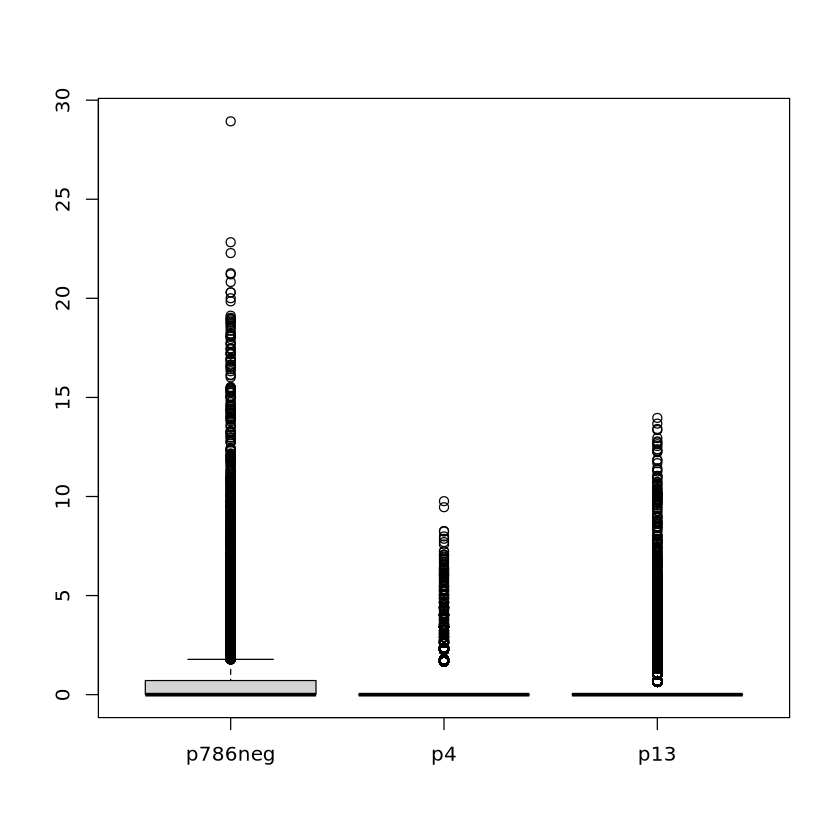

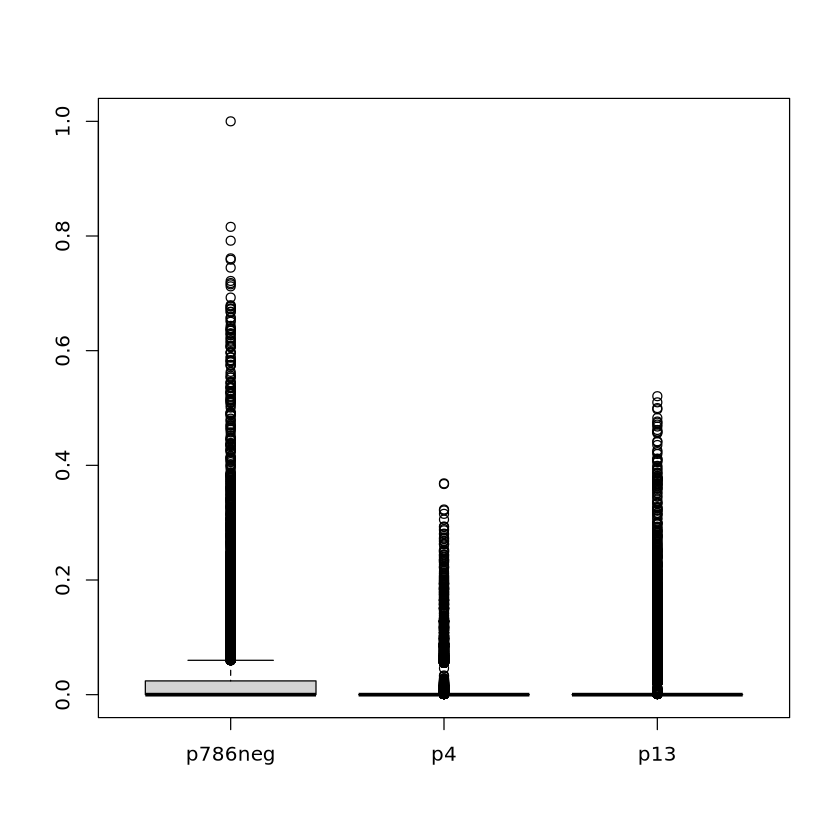

In [16]:
# vor Scaling
boxplot(trans_data)

# Limit threads (verhindert pthread-Fehler auf Clustern)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1",
           OPENBLAS_NUM_THREADS="1", VECLIB_MAXIMUM_THREADS="1")

# Versuche Quantile-Norm, sonst nimm Truncation wie in der Vignette
exp_data <- tryCatch(
  normalize_data(trans_data, by_quantiles = TRUE),
  error = function(e) {
    message("Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.")
    normalize_data(trans_data, truncation_percentil = 0.95)
  }
)

boxplot(exp_data)


In [17]:
#4.1
if (length(pathways_list) == 0) {
    message("No pathway list provided -> loading ALL pathways for ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading subset of pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# ---- Check
length(pathways)   # Anzahl geladener Pathways
names(pathways)[1:5]  # Erste 5 Pathways anzeigen
get_pathways_list(pathways)[1:10]

No pathway list provided -> loading ALL pathways for hsa

Loaded 146 pathways



[1] 7

[1] "species"     "all.genes"   "path.norm"   "eff.norm"    "pathigraphs"

[1] "hsa03320" "hsa03460" "hsa04010" "hsa04012" "hsa04014" "hsa04015"
 [7] "hsa04020" "hsa04022" "hsa04024" "hsa04062"

In [18]:
#4.3 Using Hipathia to comute the signal
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

Added missing genes: 55 (0.25%)



In [19]:
#4.3 Using Hipathia to comute the signal
results

A MultiAssayExperiment object of 2 listed
 experiments with user-defined names and respective classes.
 Containing an ExperimentList class object of length 2:
 [1] nodes: SummarizedExperiment with 6826 rows and 3 columns
 [2] paths: SummarizedExperiment with 1876 rows and 3 columns
Functionality:
 experiments() - obtain the ExperimentList instance
 colData() - the primary/phenotype DataFrame
 sampleMap() - the sample coordination DataFrame
 `$`, `[`, `[[` - extract colData columns, subset, or experiment
 *Format() - convert into a long or wide DataFrame
 assays() - convert ExperimentList to a SimpleList of matrices
 exportClass() - save data to flat files

In [20]:
#4.3 Using Hipathia to comute the signal
path_vals <- get_paths_data(results)
hhead(path_vals, 4)

,p786neg,p4,p13
P-hsa03320-37,0,0,0
P-hsa03320-61,0,0,0
P-hsa03320-46,0,0,0
P-hsa03320-57,0,0,0


#5 Function activation computation
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")
#142/1654 soll so sein

In [21]:
#6.1  Two classes comparison
design <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)
design <- design[!duplicated(design$orig.ident), c("orig.ident","group")]
rownames(design) <- design$orig.ident

sample_group <- design[colnames(path_vals), "group"]
comp <- do_wilcoxon(path_vals[, names(sample_group), drop = FALSE], sample_group, g1 = "Tumor", g2 = "Normal")
head(comp)


ERROR: Error in `[<-.data.frame`(`*tmp*`, data2$statistic > 0, "UP/DOWN", value = "UP"): missing values are not allowed in subscripted assignments of data frames


In [ ]:
#6.1  Two classes comparison
pathways_summary <- get_pathways_summary(comp, pathways)
head(pathways_summary, 4)

In [ ]:
#6.2 Pricipal Components ANalysis
ranked_path_vals <- path_vals[order(comp$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])

In [ ]:
#7Heatmap
heatmap_plot(path_vals, group = sample_group)


In [ ]:
# This should be TRUE; if FALSE, you sorted columns/rows inkonsistent
all(rownames(ranked_path_vals) %in% rownames(path_vals))
all(rownames(ranked_path_vals)[1:5] == rownames(comp)[order(comp$p.value, decreasing=FALSE, na.last=NA)][1:5])


In [ ]:
heatmap_plot(uniprot_vals, group = sample_group, colors="hipathia",
variable_clust = TRUE)
heatmap_plot(go_vals, group = sample_group, colors="redgreen",
variable_clust = TRUE)

In [ ]:
pca_plot(pca_model, sample_group, legend = TRUE)

In [ ]:
pca_plot(pca_model, sample_group, legend = TRUE)

In [ ]:

pca_plot(pca_model, group = rep(1:5, 8), main = "Random types",
legend = TRUE)

In [ ]:
multiple_pca_plot(pca_model, sample_group, cex=3, plot_variance = TRUE)

In [ ]:
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320")

In [ ]:
colors_de <- node_color_per_de(results, pathways, sample_group, "Tumor",
"Normal")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de)

In [ ]:
colors_de_hipathia <- node_color_per_de(results, pathways, sample_group,
"Tumor", "Normal", colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de_hipathia, colors = "hipathia")
pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = colors_de_hipathia,
  colors = "hipathia",
)

In [ ]:
#7.4. Vizualization through a local server
report <- create_report(comp, pathways, "save_noColors")
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...
#report_colors <- create_report(comp, pathways, "save_colors",
#node_colors = colors_de)
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...


In [ ]:

visualize_report(report, port = 4002)

In [ ]:
# 1) alte servr-Prozesse beenden
if (requireNamespace("servr", quietly = TRUE)) {
  dl <- try(servr::daemon_list(), silent = TRUE)
  if (!inherits(dl, "try-error") && NROW(dl)) {
    for (i in dl$id) try(servr::daemon_stop(i), silent = TRUE)
  }
}

# 2) freien Port wählen
port <- servr::random_port()  # nimmt garantiert freien Port, z.B. 4010

# 3) Report visualisieren
visualize_report(report, port = port)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
comp$FDRp.value <- runif(nrow(comp), 0, 0.01)  # zufällige kleine Werte
comp$UP.DOWN <- sample(c("UP","DOWN"), nrow(comp), replace = TRUE)

pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = node_color_per_de(results, pathways, sample_group,
                                  "Tumor", "Normal", colors = "hipathia"),
  colors = "hipathia"
)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
table(design$group)


In [ ]:
table(meta$group, meta$orig.ident)
